<a href="https://colab.research.google.com/github/Ashrafalaghbari/oil-production-forecasting/blob/main/optimal_LSTM_GA_single_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%autosave 60

Autosaving every 60 seconds


In [3]:
pip install keras-tcn --no-dependencies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import itertools
import re
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Activation, Dropout
from keras.layers import LSTM, Conv1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math 

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# # check if GPU is utilized 
# device_name = tf.config.experimental.list_physical_devices()[-1][-1]
# if device_name != 'GPU':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(tf.test.gpu_device_name()))

In [5]:
# Select the best features
def select_features(df, target, correlation_type, threshold):
    if (threshold < -1 ) | (threshold > 1 ) :
            raise SystemError('correlation threshold is out of bounds')
    features = df.corr(correlation_type).loc[target].drop(target)
    best_features = features.where(abs(features) > threshold).dropna()
    df = pd.concat([df[target], df[best_features.index]], axis=1)
    return df

# convert series to supervised learning using a sliding  window approach
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# scale train and test data to new feature range[0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


# inverse differencing
def inverse_difference(history, interval=1):
	return history[-len(test_scaled)-interval:-interval]

#Evaluation metrics
# compute RMSPE
def RMSPE(x,y):
	result=0
	for i in range(len(x)):
		result += ((x[i]-y[i])/x[i])**2
	result /= len(x)
	result = sqrt(result)
	result *= 100
	return result

# compute MAPE
def MAPE(x,y):
	result=0
	for i in range(len(x)):
		result += abs((x[i]-y[i])/x[i])
	result /= len(x)
	result *= 100
	return result

# compute wMAPE weighted absolute percentage error
def wMAPE(actual, predicted): 
    result_nom = 0
    result_deno = 0
    for i in range(len(actual)):
        result_nom +=  abs(actual[i] - predicted[i])
        result_deno +=  abs(actual[i]) 
    result = result_nom/result_deno
    return result *100

def SMAPE(actual, predicted): #Symmetric (adjusted) MEAN ABSOLUTE PERCENTAGE ERROR (SMAPE)
    result = 0
    for i in range(len(actual)):
        result += abs(actual[i] - predicted[i])/(abs(actual[i]) + abs(predicted[i]))
    result = 2 * result/ len(actual) 
    return result * 100

In [6]:
#load dataset
series = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv', 
                     parse_dates=["DATEPRD"], index_col="DATEPRD")
days = pd.Series(range(len(series),0, -1 ), index=series.index)
series.insert(0, 'days', days)
series['days1'] = series['days'].shift(-1)
series["AVG_CHOKE_SIZE_P1"] = series['AVG_CHOKE_SIZE_P'].shift(-1)
series["ON_STREAM_HRS1"] = series['ON_STREAM_HRS'].shift(-1)


series['interaction_effect_onNext_oil1'] = series["AVG_CHOKE_SIZE_P1"]  * series["ON_STREAM_HRS1"] * series['days']

series.dropna(inplace=True)




# # # # select feature based on correlation
# # series = select_features(series, "BORE_OIL_VOL", "spearman", 0.2)
# # select features manually
series =series[[
                'interaction_effect_onNext_oil1',
                "BORE_GAS_VOL", 
                "BORE_OIL_VOL"
                ]] 
series.shape             

(1907, 3)

In [8]:
series

,interaction_effect_onNext_oil1,BORE_GAS_VOL,BORE_OIL_VOL
DATEPRD,,,
2010-01-01,2.321410e+06,1.462166e+07,18593.749401
2010-01-02,2.181563e+06,1.469266e+07,18701.242265
2010-01-03,2.045042e+06,1.400904e+07,17799.912406
2010-01-04,2.091405e+06,1.341015e+07,17002.616014
2010-01-05,2.104483e+06,1.361768e+07,17270.939334
...,...,...,...
2015-03-18,1.440000e+04,1.354500e+06,1659.440731
2015-03-19,1.200000e+04,1.366424e+06,1662.711432
2015-03-20,9.600000e+03,1.397308e+06,1707.494884


In [7]:
# Create a new directory in My Drive
directory = '/content/drive/My Drive/my_trained_models'
if not os.path.exists(directory):
    os.makedirs(directory)

In [11]:
# # # convert series to stationary 
series_diff = series.copy()
# diff_order = 1
# series_diff['BORE_OIL_VOL'] = series_diff['BORE_OIL_VOL'].diff(diff_order)

# Define window size and number of the steps ahead for forecasting
window_size = 4
steps_ahead = 1

# # convert the stationary series to supervise learning using sliding window approach
series_supervised = series_to_supervised(series_diff, series_diff.columns, n_in= window_size, n_out= steps_ahead, dropnan=True)   

# drop columns we don't want to predict
pattern = re.compile(r"(t-)|^BORE_OIL_VOL.*")

# Extract the column names that match the pattern
matching_columns = [col for col in series_supervised.columns if re.search(pattern, col)]
series_supervised = series_supervised[matching_columns]

In [ ]:
series_supervised

,interaction_effect_onNext_oil1(t-4),BORE_OIL_VOL(t-4),interaction_effect_onNext_oil1(t-3),BORE_OIL_VOL(t-3),interaction_effect_onNext_oil1(t-2),BORE_OIL_VOL(t-2),interaction_effect_onNext_oil1(t-1),BORE_OIL_VOL(t-1),BORE_OIL_VOL(t)
DATEPRD,,,,,,,,,
2010-01-05,2.321410e+06,18593.749401,2.181563e+06,18701.242265,2.045042e+06,17799.912406,2.091405e+06,17002.616014,17270.939334
2010-01-06,2.181563e+06,18701.242265,2.045042e+06,17799.912406,2.091405e+06,17002.616014,2.104483e+06,17270.939334,17331.761803
2010-01-07,2.045042e+06,17799.912406,2.091405e+06,17002.616014,2.104483e+06,17270.939334,2.043370e+06,17331.761803,17138.601719
2010-01-08,2.091405e+06,17002.616014,2.104483e+06,17270.939334,2.043370e+06,17331.761803,2.045269e+06,17138.601719,17127.657449
2010-01-09,2.104483e+06,17270.939334,2.043370e+06,17331.761803,2.045269e+06,17138.601719,1.724474e+06,17127.657449,14477.823141
...,...,...,...,...,...,...,...,...,...
2015-03-18,2.400000e+04,1627.740085,2.160000e+04,1613.713808,1.920000e+04,1630.318908,1.680000e+04,1649.125441,1659.440731
2015-03-19,2.160000e+04,1613.713808,1.920000e+04,1630.318908,1.680000e+04,1649.125441,1.440000e+04,1659.440731,1662.711432
2015-03-20,1.920000e+04,1630.318908,1.680000e+04,1649.125441,1.440000e+04,1659.440731,1.200000e+04,1662.711432,1707.494884


In [12]:

# # split into train and test sets
n_features = int((len(series_supervised.columns) -steps_ahead)/window_size)
series_supervised = series_supervised.values
train_size = int(series_supervised.shape[0] * 0.8)
test_size = series_supervised.shape[0] - train_size
train, test = series_supervised[0:train_size], series_supervised[train_size:]
print("train.shape:",train.shape, "test.shape:",test.shape)

# scale  the data to a feature range(0,1)
scaler, train_scaled, test_scaled = scale(train, test)
print('train_scaled.shape:',train_scaled.shape, "test_scaled.shape:",test_scaled.shape)

# # reshape input to be 3D [samples, window_size, features]
train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
train_X = train_X.reshape(train_X.shape[0], window_size, n_features)
test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
test_X = test_X.reshape(test_X.shape[0], window_size, n_features )
print("train_X.shape:",train_X.shape, "train_y.shape:",train_y.shape,
        "test_X.shape:", test_X.shape,"test_y.shape:",test_y.shape)

train.shape: (1522, 13) test.shape: (381, 13)
train_scaled.shape: (1522, 13) test_scaled.shape: (381, 13)
train_X.shape: (1522, 4, 3) train_y.shape: (1522, 1) test_X.shape: (381, 4, 3) test_y.shape: (381, 1)


In [ ]:
#grid search 
def get_hyper_param(n_epochs, num_hidden_layers, num_neurons, batch_size, window_size):
    """ 
    This is a grid search function that generates all possible comibinations
    from the search space 

    Args:
    n_epochs: number of epochs
    num_hidden_layers: number of hidden layers
    num_neurons: number of neurons same for both input and hidden layers 
    batch_size: number of batch size 
    window_size: historical timesteps in the sliding window
    
    """
    hyper_param = []
    for current_params in itertools.product(n_epochs, num_hidden_layers, num_neurons, batch_size, window_size):
        hyper_param.append(list(current_params))
    return hyper_param

# Seacrh space
n_epochs = [500]
num_hidden_layers = [1, 2]
num_neurons = [4, 8, 16, 32, 64]
batch_size = [2, 4]
window_size = [2, 3, 4, 5, 6]

hyper_param = get_hyper_param(n_epochs, num_hidden_layers, num_neurons, batch_size, window_size)
len(hyper_param)# print the number of combinations
hyper_param = hyper_param[:2]

In [ ]:
#hyperparamter tuning
def fit_lstm(steps_ahead = 1):
    
        # Create a new directory in My Drive
    directory = '/content/drive/My Drive/my_trained_models'
    if not os.path.exists(directory):
        os.makedirs(directory)

    # setting the session configurations for reproducibility.
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    np.random.seed(12345)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                            inter_op_parallelism_threads=1)
    from keras import backend as K
    tf.random.set_seed(1234)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                                config=session_conf)
    K.set_session(sess)
  



    min_val_loss = math.inf 
    for n_epochs, num_hidden_layers, num_neurons, batch_size, window_size in hyper_param:
        print('n_epochs', n_epochs, 'num_hidden_layers', num_hidden_layers, 'num_neurons',
              num_neurons, "batch_size", batch_size, 'window_size', window_size)
        combinations = [n_epochs, num_hidden_layers, num_neurons, batch_size, window_size]

        #feature engineering
        # # convert the stationary series to supervise learning
        series_supervised = series_to_supervised(series_diff, series_diff.columns, n_in= window_size, n_out= steps_ahead, dropnan=True)   

        # drop columns we don't want to predict
        pattern = re.compile(r"(t-)|^BORE_OIL_VOL.*")
        # Extract the column names that match the pattern
        matching_columns = [col for col in series_supervised.columns if re.search(pattern, col)]
        series_supervised = series_supervised[matching_columns]

        # # split into train and test sets
        series_supervised = series_supervised.values
        train_size = int(series_supervised.shape[0] * 0.8)
        test_size = series_supervised.shape[0] - train_size
        train, test = series_supervised[0:train_size], series_supervised[train_size:]
        print("train.shape:",train.shape, "test.shape:",test.shape)

        # scale  the data to a feature range(0,1)
        scaler, train_scaled, test_scaled = scale(train, test)
        print('train_scaled.shape:',train_scaled.shape, "test_scaled.shape:",test_scaled.shape)

        # reshape input to be 3D [samples, window_size, features]
        n_features = len(series.columns)
        train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
        train_X = train_X.reshape(train_X.shape[0], window_size, n_features)
        test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
        test_X = test_X.reshape(test_X.shape[0], window_size, n_features )
        print("train_X.shape:",train_X.shape, "train_y.shape:",train_y.shape,
              "test_X.shape:", test_X.shape,"test_y.shape:",test_y.shape)
        
        # instantiate the LSTM model
        model = Sequential()

        if num_hidden_layers != 1:
  
            for num in range(num_hidden_layers-1):
                model.add(LSTM(num_neurons, input_shape=(window_size, n_features), return_sequences=True))
            model.add(LSTM(num_neurons))

        else:
            model.add(LSTM(num_neurons, input_shape=(window_size, n_features)))
        model.add(Dense(steps_ahead)) # output layer
        model.compile(loss='mean_squared_error',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

        
        #prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2,
                                restore_best_weights=True, mode='min')
        
        # save the best weights
        mcp_save = ModelCheckpoint(os.path.join(directory, f'{combinations}_weights.hdf5'),
                            save_best_only=True,
                            monitor='val_loss', mode='min') 
        # fit model
        lstm_model = model.fit(train_X, train_y, epochs=n_epochs,
                            callbacks=[early_stopping, mcp_save],
                            batch_size=batch_size,
                            validation_data=(test_X, test_y), verbose=2, shuffle=False)
        
        # Save the model  in HDF5 foramt with a filename that includes the hyperparamters
        model.save(os.path.join(directory, f'{combinations}_model.h5'))
        # Load the best weights
        model.load_weights(os.path.join(directory, f'{combinations}_weights.hdf5'))
        current_val_loss = model.evaluate(test_X, test_y, verbose=0) #lstm_model.history['val_loss'][-1]
        if current_val_loss < min_val_loss:
            min_val_loss = current_val_loss
            best_params = [n_epochs,  num_hidden_layers, num_neurons, batch_size, window_size]

        
    print('final best params',"n_epochs:",best_params[0],"num_hidden_layers:",
          best_params[1], "num_neurons:", best_params[2], "batch_size:", best_params[3],
          "window_size:",best_params[4]) 
    return {"best_params": str(best_params) , "MSE": min_val_loss}#, lstm_model

In [ ]:
# # run the model and repeat the evaluation to reduce the certainty asscoicated with the random initialization of model weights
# def run_model(n_repeats = 1):
#     scores = [fit_lstm_random() for _ in range(n_repeats)]
#     result = pd.DataFrame(scores)
#     result = result.groupby("best_params").mean()
#     return result

In [ ]:
fit_lstm()

n_epochs 500 num_hidden_layers 1 num_neurons 4 batch_size 2 window_size 2
train.shape: (1524, 7) test.shape: (381, 7)
train_scaled.shape: (1524, 7) test_scaled.shape: (381, 7)
train_X.shape: (1524, 2, 3) train_y.shape: (1524, 1) test_X.shape: (381, 2, 3) test_y.shape: (381, 1)
Epoch 1/500
762/762 - 4s - loss: 0.0650 - val_loss: 4.9336e-04 - 4s/epoch - 6ms/step
Epoch 2/500
762/762 - 2s - loss: 0.0241 - val_loss: 0.0028 - 2s/epoch - 2ms/step
Epoch 3/500
762/762 - 1s - loss: 0.0143 - val_loss: 0.0026 - 1s/epoch - 2ms/step
Epoch 4/500
762/762 - 1s - loss: 0.0122 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 5/500
762/762 - 2s - loss: 0.0112 - val_loss: 0.0011 - 2s/epoch - 2ms/step
Epoch 6/500
762/762 - 2s - loss: 0.0104 - val_loss: 7.2967e-04 - 2s/epoch - 2ms/step
Epoch 7/500
762/762 - 1s - loss: 0.0099 - val_loss: 5.4199e-04 - 1s/epoch - 2ms/step
Epoch 8/500
762/762 - 2s - loss: 0.0095 - val_loss: 4.4359e-04 - 2s/epoch - 2ms/step
Epoch 9/500
762/762 - 2s - loss: 0.0092 - val_loss: 3.9415

{'best_params': '[500, 1, 4, 2, 3]', 'MSE': 0.00019997876370325685}

In [13]:
from numpy.random import randint, rand

In [14]:
# initial population of random bitstring
n_bits = 8 # number of bits for each individual
n_pop= 2 # number of experiments
pop = [randint(0, 2, n_bits) for _ in range(n_pop)]
# define range for input
bounds = [[2, 32]]

# initial population of random bitstring
pop = [randint(0, 2, n_bits*len(bounds)).tolist() for _ in range(n_pop)]
pop

[[0, 0, 1, 1, 0, 1, 1, 1], [1, 1, 1, 0, 1, 0, 0, 1]]

In [570]:

# decode population
decoded = [decode(bounds, n_bits, p) for p in pop]
decoded

[[27], [17]]

In [22]:
# decode bitstring to numbers
def decode(bounds, n_bits, bitstring):
    decoded = list()
    largest = 2**n_bits
    for i in range(len(bounds)):
        # extract the substring
        start, end = i * n_bits, (i * n_bits)+n_bits
        substring = bitstring[start:end]
        # convert bitstring to a string of chars
        chars = ''.join([str(s) for s in substring])
        # convert string to integer
        integer = int(chars, 2)
        # scale integer to desired range
        value = bounds[i][0] + (integer/largest) * (bounds[i][1] - bounds[i][0])
        value = np.round(value)
        value = int(value)
        # store
        decoded.append(value)
    return decoded

In [563]:
# evaluate all candidates in the population
scores = [evaluate(d) for d in decoded]

Epoch 1/10
381/381 - 3s - loss: 0.1639 - val_loss: 8.4715e-04 - 3s/epoch - 9ms/step
Epoch 2/10
381/381 - 1s - loss: 0.0519 - val_loss: 0.0071 - 1s/epoch - 3ms/step
Epoch 3/10
381/381 - 1s - loss: 0.0217 - val_loss: 0.0072 - 1s/epoch - 3ms/step
Epoch 4/10
381/381 - 1s - loss: 0.0175 - val_loss: 0.0053 - 979ms/epoch - 3ms/step
Epoch 5/10
381/381 - 1s - loss: 0.0156 - val_loss: 0.0037 - 1s/epoch - 3ms/step
Epoch 6/10
381/381 - 1s - loss: 0.0142 - val_loss: 0.0027 - 985ms/epoch - 3ms/step
Epoch 7/10
381/381 - 1s - loss: 0.0131 - val_loss: 0.0020 - 996ms/epoch - 3ms/step
Epoch 8/10
381/381 - 1s - loss: 0.0122 - val_loss: 0.0015 - 1s/epoch - 3ms/step
Epoch 9/10
381/381 - 1s - loss: 0.0116 - val_loss: 0.0012 - 1s/epoch - 3ms/step
Epoch 10/10
381/381 - 1s - loss: 0.0111 - val_loss: 0.0010 - 1s/epoch - 3ms/step
12/12 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1/10
381/381 - 3s - loss: 0.1973 - val_loss: 0.0039 - 3s/epoch - 8ms/step
Epoch 2/10
381/381 - 1s - loss: 0.0967

In [564]:
scores

[0.0010407392401248217, 0.002341017359867692]

In [567]:
# keep track of best solution
best, best_eval = 0, evaluate(pop[0])

Epoch 1/10
381/381 - 4s - loss: 0.1177 - val_loss: 0.0022 - 4s/epoch - 11ms/step
Epoch 2/10
381/381 - 1s - loss: 0.0839 - val_loss: 4.8181e-04 - 1s/epoch - 3ms/step
Epoch 3/10
381/381 - 1s - loss: 0.0565 - val_loss: 0.0023 - 994ms/epoch - 3ms/step
Epoch 4/10
381/381 - 1s - loss: 0.0395 - val_loss: 0.0055 - 991ms/epoch - 3ms/step
Epoch 5/10
381/381 - 1s - loss: 0.0304 - val_loss: 0.0081 - 954ms/epoch - 3ms/step
Epoch 6/10
381/381 - 1s - loss: 0.0259 - val_loss: 0.0093 - 992ms/epoch - 3ms/step
Epoch 7/10
381/381 - 1s - loss: 0.0235 - val_loss: 0.0093 - 1s/epoch - 3ms/step
Epoch 8/10
381/381 - 1s - loss: 0.0220 - val_loss: 0.0086 - 1s/epoch - 3ms/step
Epoch 9/10
381/381 - 1s - loss: 0.0209 - val_loss: 0.0075 - 1s/epoch - 3ms/step
Epoch 10/10
381/381 - 1s - loss: 0.0199 - val_loss: 0.0064 - 1s/epoch - 3ms/step
12/12 [==============================] - 0s 2ms/step - loss: 0.0064


In [71]:
for i in range(2-1):
    print(i)

0


In [16]:
from keras.layers import Input
from keras.models import Model

In [ ]:
# Seacrh space
n_epochs = [500]
num_hidden_layers = [1, 2]
num_neurons = [4, 8, 16, 32, 64]
batch_size = [2, 4]
window_size = [2, 3, 4, 5, 6]

In [137]:
    #feature engineering
    window_size=7
    steps_ahead=1
    # # convert the stationary series to supervise learning
    series_supervised = series_to_supervised(series, series.columns, n_in= window_size, n_out= steps_ahead, dropnan=True) 
    series_supervised

,interaction_effect_onNext_oil1(t-7),BORE_GAS_VOL(t-7),BORE_OIL_VOL(t-7),interaction_effect_onNext_oil1(t-6),BORE_GAS_VOL(t-6),BORE_OIL_VOL(t-6),interaction_effect_onNext_oil1(t-5),BORE_GAS_VOL(t-5),BORE_OIL_VOL(t-5),interaction_effect_onNext_oil1(t-4),...,BORE_OIL_VOL(t-3),interaction_effect_onNext_oil1(t-2),BORE_GAS_VOL(t-2),BORE_OIL_VOL(t-2),interaction_effect_onNext_oil1(t-1),BORE_GAS_VOL(t-1),BORE_OIL_VOL(t-1),interaction_effect_onNext_oil1(t),BORE_GAS_VOL(t),BORE_OIL_VOL(t)
DATEPRD,,,,,,,,,,,,,,,,,,,,,
2010-01-08,2.321410e+06,1.462166e+07,18593.749401,2.181563e+06,1.469266e+07,18701.242265,2.045042e+06,1.400904e+07,17799.912406,2.091405e+06,...,17270.939334,2.043370e+06,1.364834e+07,17331.761803,2.045269e+06,1.350971e+07,17138.601719,1.724474e+06,1.349732e+07,17127.657449
2010-01-09,2.181563e+06,1.469266e+07,18701.242265,2.045042e+06,1.400904e+07,17799.912406,2.091405e+06,1.341015e+07,17002.616014,2.104483e+06,...,17331.761803,2.045269e+06,1.350971e+07,17138.601719,1.724474e+06,1.349732e+07,17127.657449,2.049433e+06,1.192758e+07,14477.823141
2010-01-10,2.045042e+06,1.400904e+07,17799.912406,2.091405e+06,1.341015e+07,17002.616014,2.104483e+06,1.361768e+07,17270.939334,2.043370e+06,...,17138.601719,1.724474e+06,1.349732e+07,17127.657449,2.049433e+06,1.192758e+07,14477.823141,2.090917e+06,1.350295e+07,17149.483091
2010-01-11,2.091405e+06,1.341015e+07,17002.616014,2.104483e+06,1.361768e+07,17270.939334,2.043370e+06,1.364834e+07,17331.761803,2.045269e+06,...,17127.657449,2.049433e+06,1.192758e+07,14477.823141,2.090917e+06,1.350295e+07,17149.483091,2.095638e+06,1.343582e+07,17073.250587
2010-01-12,2.104483e+06,1.361768e+07,17270.939334,2.043370e+06,1.364834e+07,17331.761803,2.045269e+06,1.350971e+07,17138.601719,1.724474e+06,...,14477.823141,2.090917e+06,1.350295e+07,17149.483091,2.095638e+06,1.343582e+07,17073.250587,2.109894e+06,1.339754e+07,17056.834181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-18,3.120000e+04,1.366879e+06,1643.024325,2.880000e+04,1.365665e+06,1639.439133,2.640000e+04,1.363799e+06,1618.116675,2.400000e+04,...,1613.713808,1.920000e+04,1.344981e+06,1630.318908,1.680000e+04,1.348689e+06,1649.125441,1.440000e+04,1.354500e+06,1659.440731
2015-03-19,2.880000e+04,1.365665e+06,1639.439133,2.640000e+04,1.363799e+06,1618.116675,2.400000e+04,1.362575e+06,1627.740085,2.160000e+04,...,1630.318908,1.680000e+04,1.348689e+06,1649.125441,1.440000e+04,1.354500e+06,1659.440731,1.200000e+04,1.366424e+06,1662.711432
2015-03-20,2.640000e+04,1.363799e+06,1618.116675,2.400000e+04,1.362575e+06,1627.740085,2.160000e+04,1.337302e+06,1613.713808,1.920000e+04,...,1649.125441,1.440000e+04,1.354500e+06,1659.440731,1.200000e+04,1.366424e+06,1662.711432,9.600000e+03,1.397308e+06,1707.494884


In [184]:
def evaluate_LSTM(individual, steps_ahead=1):
    n_epochs = individual[0]
    num_hidden_layers = individual[1]
    num_neurons = individual[2]
    batch_size = individual[3]
    window_size = individual[4]


    # setting the session configurations for reproducibility.
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    np.random.seed(12345)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                            inter_op_parallelism_threads=1)
    from keras import backend as K
    tf.random.set_seed(1234)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                                config=session_conf)
    K.set_session(sess)
  

    print('n_epochs', n_epochs, 'num_hidden_layers', num_hidden_layers, 'num_neurons',
              num_neurons, "batch_size", batch_size, 'window_size', window_size)


    #feature engineering
    # # convert the stationary series to supervise learning
    series_supervised = series_to_supervised(series, series.columns, n_in= window_size, n_out= steps_ahead, dropnan=True)   

    # drop columns we don't want to predict
    pattern = re.compile(r"(t-)|^BORE_OIL_VOL.*")
    # Extract the column names that match the pattern
    matching_columns = [col for col in series_supervised.columns if re.search(pattern, col)]
    series_supervised = series_supervised[matching_columns]

    # # split into train and test sets
    series_supervised = series_supervised.values
    train_size = int(series_supervised.shape[0] * 0.8)
    test_size = series_supervised.shape[0] - train_size
    train, test = series_supervised[0:train_size], series_supervised[train_size:]
    print("train.shape:",train.shape, "test.shape:",test.shape)

    # scale  the data to a feature range(0,1)
    scaler, train_scaled, test_scaled = scale(train, test)
    print('train_scaled.shape:',train_scaled.shape, "test_scaled.shape:",test_scaled.shape)

    # reshape input to be 3D [samples, window_size, features]
    n_features = len(series.columns)
    train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
    train_X = train_X.reshape(train_X.shape[0], window_size, n_features)
    test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
    test_X = test_X.reshape(test_X.shape[0], window_size, n_features )
    print("train_X.shape:",train_X.shape, "train_y.shape:",train_y.shape,
            "test_X.shape:", test_X.shape,"test_y.shape:",test_y.shape)

    # build the model
    input_tensor=Input(shape=(window_size, n_features))

    if num_hidden_layers != 1:
        for num in range(num_hidden_layers-1):
            lstm_1 = LSTM(num_neurons,activation='tanh', input_shape=(window_size, n_features), 
                          return_sequences=True)(input_tensor)
        lstm_2 = LSTM(num_neurons)(lstm_1)
    else:
        lstm_1 = LSTM(num_neurons, activation='tanh', input_shape=(window_size, n_features))(input_tensor)   
    lstm_output = LSTM(num_neurons, activation='tanh')(input_tensor)    
    outputs = Dense(steps_ahead)(lstm_output)
    model = Model(input_tensor, outputs)

    model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
    #prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2,
                                restore_best_weights=True, mode='min')
    
    model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, callbacks = [early_stopping],
              validation_data=(test_X, test_y), verbose=2, shuffle=False)
    
    return model.evaluate(test_X, test_y, verbose=0)

In [ ]:
def evaluate_TCN(individual, steps_ahead=1):
    n_epochs = individual[0]
    num_hidden_layers = individual[1]
    num_neurons = individual[2]
    batch_size = individual[3]
    window_size = individual[4]


    # setting the session configurations for reproducibility.
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    np.random.seed(12345)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                            inter_op_parallelism_threads=1)
    from keras import backend as K
    tf.random.set_seed(1234)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                                config=session_conf)
    K.set_session(sess)
  

    # print('n_epochs', n_epochs, 'num_hidden_layers', num_hidden_layers, 'num_neurons',
    #           num_neurons, "batch_size", batch_size, 'window_size', window_size)


    #feature engineering
    # # convert the stationary series to supervise learning
    series_supervised = series_to_supervised(series, series.columns, n_in= window_size, n_out= steps_ahead, dropnan=True)   

    # drop columns we don't want to predict
    pattern = re.compile(r"(t-)|^BORE_OIL_VOL.*")
    # Extract the column names that match the pattern
    matching_columns = [col for col in series_supervised.columns if re.search(pattern, col)]
    series_supervised = series_supervised[matching_columns]

    # # split into train and test sets
    series_supervised = series_supervised.values
    train_size = int(series_supervised.shape[0] * 0.8)
    test_size = series_supervised.shape[0] - train_size
    train, test = series_supervised[0:train_size], series_supervised[train_size:]
    # print("train.shape:",train.shape, "test.shape:",test.shape)

    # scale  the data to a feature range(0,1)
    scaler, train_scaled, test_scaled = scale(train, test)
    # print('train_scaled.shape:',train_scaled.shape, "test_scaled.shape:",test_scaled.shape)

    # reshape input to be 3D [samples, window_size, features]
    n_features = len(series.columns)
    train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
    train_X = train_X.reshape(train_X.shape[0], window_size, n_features)
    test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
    test_X = test_X.reshape(test_X.shape[0], window_size, n_features )
    print("train_X.shape:",train_X.shape, "train_y.shape:",train_y.shape,
            "test_X.shape:", test_X.shape,"test_y.shape:",test_y.shape)

    # build the model
    input_tensor=Input(shape=(window_size, n_features))

    if num_hidden_layers != 1:
        for num in range(num_hidden_layers-1):
            lstm_1 = LSTM(num_neurons,activation='tanh', input_shape=(window_size, n_features), 
                          return_sequences=True)(input_tensor)
        lstm_2 = LSTM(num_neurons)(lstm_1)
    else:
        lstm_1 = LSTM(num_neurons, activation='tanh', input_shape=(window_size, n_features))(input_tensor)   
    lstm_output = LSTM(num_neurons, activation='tanh')(input_tensor)    
    outputs = Dense(steps_ahead)(lstm_output)
    model = Model(input_tensor, outputs)

    model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
    #prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2,
                                restore_best_weights=True, mode='min')
    
    model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, callbacks = [early_stopping],
              validation_data=(test_X, test_y), verbose=2, shuffle=False)
    
    return model.evaluate(test_X, test_y, verbose=0)

In [ ]:
# define the search space
n_epochs = [500,500]
num_hidden_layers = [1, 2]
num_neurons = [4, 200]
batch_size = [2, 4]
window_size = [2, 12]
bounds = [n_epochs,num_hidden_layers, num_neurons, batch_size, window_size]

# define the total number of generations
n_iter = 3#0
# bits per variable
n_bits = 16
# define the number of combinations (individuals) per generation 
n_pop = 20
# crossover rate
r_cross = 0.9
# mutation rate
r_mut = 1.0 / (float(n_bits) * len(bounds))
genetic_algorithm(evaluate, bounds, n_bits, n_iter, n_pop, r_cross, r_mut)

Generation:1
n_epochs 500 num_hidden_layers 2 num_neurons 58 batch_size 2 window_size 2
train.shape: (1524, 7) test.shape: (381, 7)
train_scaled.shape: (1524, 7) test_scaled.shape: (381, 7)
train_X.shape: (1524, 2, 3) train_y.shape: (1524, 1) test_X.shape: (381, 2, 3) test_y.shape: (381, 1)
Epoch 1/500
762/762 - 4s - loss: 0.1238 - val_loss: 0.0039 - 4s/epoch - 5ms/step
Epoch 2/500
762/762 - 2s - loss: 0.0164 - val_loss: 0.0028 - 2s/epoch - 2ms/step
Epoch 3/500
762/762 - 2s - loss: 0.0131 - val_loss: 0.0017 - 2s/epoch - 2ms/step
Epoch 4/500
762/762 - 2s - loss: 0.0116 - val_loss: 0.0011 - 2s/epoch - 2ms/step
Epoch 5/500
762/762 - 2s - loss: 0.0107 - val_loss: 8.4164e-04 - 2s/epoch - 2ms/step
Epoch 6/500
762/762 - 2s - loss: 0.0101 - val_loss: 6.7812e-04 - 2s/epoch - 2ms/step
Epoch 7/500
762/762 - 2s - loss: 0.0097 - val_loss: 5.8352e-04 - 2s/epoch - 2ms/step
Epoch 8/500
762/762 - 2s - loss: 0.0094 - val_loss: 5.2432e-04 - 2s/epoch - 2ms/step
Epoch 9/500
762/762 - 2s - loss: 0.0091 - va

In [186]:
# decode bitstring to numbers
def decode(bounds, n_bits, bitstring):
    decoded = list()
    largest = 2**n_bits
    for i in range(len(bounds)):
        # extract the substring
        start, end = i * n_bits, (i * n_bits)+n_bits
        substring = bitstring[start:end]
        # convert bitstring to a string of chars
        chars = ''.join([str(s) for s in substring])
        # convert string to integer
        integer = int(chars, 2)
        # scale integer to desired range
        value = bounds[i][0] + (integer/largest) * (bounds[i][1] - bounds[i][0])
        value = np.round(value)
        value = int(value)
        # store
        decoded.append(value)
    return decoded

# tournament selection
def selection(pop, scores, k=3):
	# first random selection
	selection_ix = randint(len(pop))
	for ix in randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix] : # which individual has the lowest loss

			selection_ix = ix
	return pop[selection_ix]

# crossover two parents to create two children
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = randint(1, len(p1)-2)
		# perform crossover
		c1 = np.append(p1[:pt] , p2[pt:])
		c2 = np.append(p2[:pt] , p1[pt:])
	return [c1, c2]

# mutation operator
def mutation(bitstring, r_mut):
	for i in range(len(bitstring)):
		# check for a mutation
		if rand() < r_mut:
			# flip the bit
			bitstring[i] = 1 - bitstring[i]

# genetic algorithm
def genetic_algorithm(evaluate, bounds, n_bits, n_iter, n_pop, r_cross, r_mut):
    # initial population of random bitstring
    pop = [randint(0, 2, n_bits*len(bounds)).tolist() for _ in range(n_pop)]
    # keep track of best solution
    best, best_eval = 0, math.inf
    # enumerate generations
    for gen in range(1, n_iter+1):
        print(f"Generation:{gen}")
        # decode population
        decoded = [decode(bounds, n_bits, p) for p in pop]
        # evaluate all candidates in the population
        scores = [evaluate(ind) for ind in decoded]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval: # find the lowest validation loss
                best, best_eval = pop[i], scores[i]
                # print
                print(">%d, new best combination, Epoch: %d, num_hidden_layers: %d num_neurons:%d batch_size:\
                 %d window_size: %d  = %.8f" % \
                        (gen,  decoded[i][0],decoded[i][1], decoded[i][2], decoded[i][3], decoded[i][4],
                                                            scores[i]))
		# select parents
        selected = [selection(pop, scores) for _ in range(n_pop)]
		# create the next generation
        children = list()
        for i in range(0, n_pop, 2):
			# get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
			# crossover and mutation
            for c in crossover(p1, p2, r_cross):
				# mutation
                mutation(c, r_mut)
				# store for next generation
                children.append(c)
		# replace population
        pop = children
    return [best, best_eval]


In [ ]:
from keras.layers import Input, Add, Reshape, BatchNormalization, Concatenate, MaxPooling1D, RepeatVector, TimeDistributed, Flatten

from keras.models import Model
import keras.backend as k
from tcn import TCN
from keras.layers import GRU, RNN, Bidirectional
from keras.layers import Layer

In [ ]:
input_tensor

<KerasTensor: shape=(None, 4, 3) dtype=float32 (created by layer 'input_87')>

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)
from keras import backend as K
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
K.set_session(sess)

# fit the model
neurons=195#22
batch_size=4
window_size=4
input_tensor=Input(shape=(window_size, n_features))





conv1 = Conv1D(filters = int(n_features*2), kernel_size=1, dilation_rate=1 ,padding='same')(input_tensor)
conv2 = Conv1D(filters = int(n_features*1), kernel_size=1, dilation_rate=1, padding='same')(conv1)
conv4 = Conv1D(filters = int(n_features), kernel_size=4, dilation_rate=1, padding='causal')(conv2)


# conv2 = Conv1D(filters = int(n_features/2), kernel_size= int(window_size/2), dilation_rate=1, padding='causal')(conv1)
# tcn1 = TCN( nb_filters=int(22), return_sequences=True, kernel_size=2, dilations=[1])(input_tensor)
# tcn2 = TCN( nb_filters=22*1, return_sequences=True, kernel_size=2, dilations=[1])(tcn1)
# tcn1 = TCN( nb_filters=22*1, return_sequences=True, kernel_size=1, dilations=[1])(input_tensor)
# tcn2 = TCN( nb_filters=22/2, return_sequences=False, kernel_size=8, dilations=[1])(tcn1)
# conv3 = Conv1D(filters = (n_features*1), kernel_size=4, dilation_rate=1, padding='causal') (conv1)
# model= Sequential()
# model.add(LSTM(neurons,activation = 'tanh',input_shape=(4, n_features)) )



conv4 = Flatten()(conv4)
outputs = Dense(steps_ahead)(conv4) # output layer trainable=True
model = Model(input_tensor, outputs)
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0001))
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2,
                                restore_best_weights=True, mode='min')
# save the best weights if training is interrupted
mcp_save = ModelCheckpoint(os.path.join(directory, 'mdl_wts.hdf5'),
                            save_best_only=True,
                            monitor='val_loss', mode='min') 



# Set the initial and total number of epochs
initial_epoch = 1
n_epochs = 500
loss_tracking = list()


# Run the training loop
for epoch in range(initial_epoch , n_epochs+1):
    print(f'Epoch {epoch}/{n_epochs}')
    # Train the model for one epoch
    history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save],
                    epochs=1, batch_size=4, validation_data=(test_X, test_y),
                     verbose=2,
                     shuffle=False)
    # to find for which epoch each loss belongs
    validation_loss= model.evaluate(test_X, test_y, verbose=0)
    loss_tracking.append(validation_loss)
    # Save the model every 10 epochs
    if epoch % 100 == 0:
        # Save the model  in HDF5 foramt with a filename that includes the epoch number
        #model.save(f'model_{epoch}Eps.h5')
        model.save(os.path.join(directory, f'model_{epoch}Eps.h5'))

Epoch 1/500
381/381 - 2s - loss: 0.2452 - val_loss: 0.0139 - 2s/epoch - 5ms/step
Epoch 2/500
381/381 - 1s - loss: 0.2337 - val_loss: 0.0130 - 704ms/epoch - 2ms/step
Epoch 3/500
381/381 - 1s - loss: 0.2260 - val_loss: 0.0122 - 662ms/epoch - 2ms/step
Epoch 4/500
381/381 - 1s - loss: 0.2198 - val_loss: 0.0116 - 702ms/epoch - 2ms/step
Epoch 5/500
381/381 - 1s - loss: 0.2144 - val_loss: 0.0111 - 658ms/epoch - 2ms/step
Epoch 6/500
381/381 - 1s - loss: 0.2095 - val_loss: 0.0106 - 670ms/epoch - 2ms/step
Epoch 7/500
381/381 - 1s - loss: 0.2050 - val_loss: 0.0101 - 711ms/epoch - 2ms/step
Epoch 8/500
381/381 - 1s - loss: 0.2008 - val_loss: 0.0097 - 669ms/epoch - 2ms/step
Epoch 9/500
381/381 - 1s - loss: 0.1968 - val_loss: 0.0093 - 677ms/epoch - 2ms/step
Epoch 10/500
381/381 - 1s - loss: 0.1930 - val_loss: 0.0089 - 703ms/epoch - 2ms/step
Epoch 11/500
381/381 - 1s - loss: 0.1895 - val_loss: 0.0085 - 692ms/epoch - 2ms/step
Epoch 12/500
381/381 - 1s - loss: 0.1860 - val_loss: 0.0082 - 714ms/epoch - 2

KeyboardInterrupt: ignored

In [ ]:
model.summary()

Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 4, 22)]           0         
                                                                 
 conv1d_21 (Conv1D)          (None, 4, 1)              23        
                                                                 
 dense_53 (Dense)            (None, 4, 1)              2         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [ ]:
pip install keras-tcn --no-dependencies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tcn import TCN

In [ ]:


# conv1 = Conv1D(filters = 46, kernel_size=1, dilation_rate=1, padding='same')(input_tensor)


# conv2 = Conv1D(filters = 25, kernel_size=1, dilation_rate=1, padding='same')(conv1)


# conv3 = Conv1D(filters = 46, kernel_size=1, dilation_rate=1, padding='same')(conv2)
model = Sequential([
    model.add(Conv1D(filters = 146, kernel_size=1, dilation_rate=1, padding='same')),
    model.add(Conv1D(filters = 125, kernel_size=1, dilation_rate=1, padding='same')),
    model.add(Conv1D(filters = 110, kernel_size=1, dilation_rate=1, padding='same')),
    model.add(Conv1D(filters = 146, kernel_size=4, dilation_rate=16, padding='causal')),
    LSTM(64),
    Dense(3)
])

# model.add(Conv1D(filters = 46, kernel_size=1, dilation_rate=1, padding='same'))
# model.add(Conv1D(filters = 25, kernel_size=1, dilation_rate=1, padding='same'))
# model.add(Conv1D(filters = 10, kernel_size=1, dilation_rate=1, padding='same'))
# model.add(Conv1D(filters = 46, kernel_size=2, dilation_rate=8, padding='causal'))
# model.add(Conv1D(filters = 46, kernel_size=4, dilation_rate=16, padding='causal'))

# conv4 = Conv1D(filters = 10, kernel_size=1, dilation_rate=1, padding='same')(conv3)
# conv5 = Conv1D(filters = 10, kernel_size=1, dilation_rate=1, padding='same')(conv4)


# lstm_output = LSTM(neurons, activation="tanh")(conv3)
 
# outputs = Dense(steps_ahead)(lstm_output) # output layer
# model = Model(input_tensor, outputs)
# model.add(Dense(steps_ahead))

# Define the TCN layers
# model.add(TCN(nb_filters=46, kernel_size=1, dilations=[1,1,1], nb_stacks=3, input_shape =(window_size, n_features),
#           padding='same',# use_skip_connections=True,
#            #return_sequences=True,
#           activation='relu'#, kernel_initializer='he_normal'#,dropout_rate=0.1
#           ))
# model.add(LSTM(65))
# output layer
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))


# Set the initial and total number of epochs
initial_epoch = 1
n_epochs = 500
loss_tracking = list()

history = model.fit(train_X, train_y,
                    epochs=500, batch_size=4, validation_data=(test_X, test_y),
                     verbose=2,
                     shuffle=False)




AttributeError: ignored

In [ ]:
model.layers[0].output

<KerasTensor: shape=(None, 4, 46) dtype=float32 (created by layer 'conv1d_4')>

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)
from keras import backend as K
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
K.set_session(sess)

model = keras.models.Sequential([
    TCN(input_shape=(window_size, n_features), nb_filters=256, return_sequences=True, dilations=[1, 2, 4, 8, 16, 32]),
    keras.layers.Dense(steps_ahead)
    ])


model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2,
                                restore_best_weights=True, mode='min')
# save the best weights if training is interrupted
mcp_save = ModelCheckpoint(os.path.join(directory, 'mdl_wts.hdf5'),
                            save_best_only=True,
                            monitor='val_loss', mode='min') 


# Set the initial and total number of epochs
initial_epoch = 1
n_epochs = 700
loss_tracking = list()

# Run the training loop
for epoch in range(initial_epoch , n_epochs+1):
    print(f'Epoch {epoch}/{n_epochs}')
    # Train the model for one epoch
    history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save],
                    epochs=1, batch_size=4, validation_data=(test_X, test_y),
                     verbose=2,
                     shuffle=False)
    # to find for which epoch each loss belongs
    validation_loss= model.evaluate(test_X, test_y, verbose=0)
    loss_tracking.append(validation_loss)
    # Save the model every 10 epochs
    if epoch % 100 == 0:
        # Save the model  in HDF5 foramt with a filename that includes the epoch number
        #model.save(f'model_{epoch}Eps.h5')
        model.save(os.path.join(directory, f'model_{epoch}Eps.h5'))

NameError: ignored

In [ ]:
from tcn import TCN
from keras.layers import Input
from keras.models import Model
import keras

In [ ]:
input_tensor

<KerasTensor: shape=(None, 4, 4) dtype=float32 (created by layer 'input_4')>

In [ ]:
#  best tcn architecture is the one used in the papaer

In [ ]:
# load the trained saved model
model_saved = tf.keras.models.load_model('/content/drive/MyDrive/my_trained_models/[500, 1, 4, 2, 3]_model.h5')
# Load the best weights
model_saved.load_weights('/content/drive/MyDrive/my_trained_models/[500, 1, 4, 2, 3]_weights.hdf5')
#print the loss of the best weights
model_saved.evaluate(test_X, test_y, verbose=0)

0.00019997876370325685

In [ ]:
model_saved = tf.keras.models.load_model('/content/drive/MyDrive/my_trained_models/optimal_lstm_model_200Eps.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/my_trained_models/mdl_wts.hdf5')
model.evaluate(test_X, test_y, verbose=0)

0.000168306622072123

In [ ]:
score = model.evaluate(test_X, test_y, verbose=0)
best_epoch = loss_tracking.index(score) + 1
# validation loss and corresponding epoch for the saved model
print(f'Epoch:{best_epoch}\nValidation loss: {score}') 

Epoch:121
Validation loss: 0.0007662050193175673


In [ ]:
# # continue if training is interrupted 
# model.compile(loss='mean_squared_error',
#               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))
# early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2,
#                                 restore_best_weights=True, mode='min')
# # save the best weights if training is interrupted
# mcp_save = ModelCheckpoint(os.path.join(directory, 'mdl_wts.hdf5'),
#                             save_best_only=True,
#                             monitor='val_loss', mode='min') 
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='min')

# # Set the initial and total number of epochs
# initial_epoch = 1
# n_epochs = 2000

# # Run the training loop
# for epoch in range(initial_epoch , n_epochs+1):
#     print(f'Epoch {epoch}/{n_epochs}')
#     # Train the model for one epoch
#     history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save, reduce_lr_loss],
#                     epochs=1, batch_size=2, validation_data=(test_X, test_y),
#                      verbose=2,
#                      shuffle=False)
#     # to find for which epoch each loss belongs
#     validation_loss= model.evaluate(test_X, test_y, verbose=0)
#     loss_tracking.append(validation_loss)
#     # Save the model every 10 epochs
#     if epoch % 50 == 0:
#         # Save the model  in HDF5 foramt with a filename that includes the epoch number
#         #model.save(f'model_{epoch}Eps.h5')
#         model.save(os.path.join(directory, f'model_{epoch}Eps.h5'))

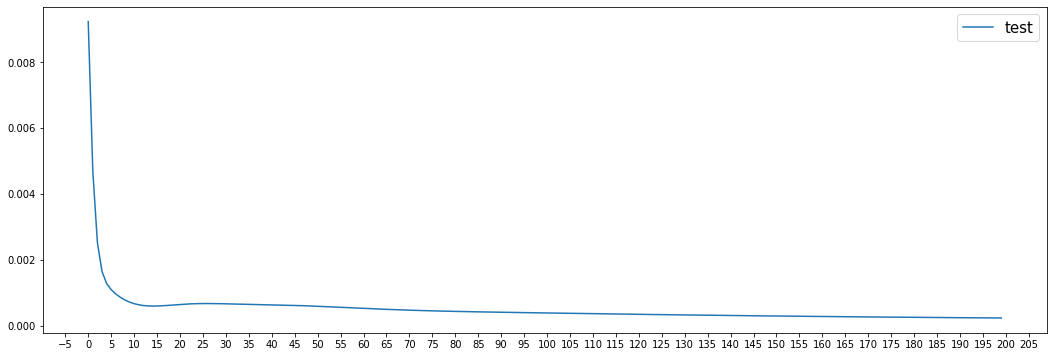

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
#plt.plot(history.history['loss'], label='train')
plt.plot(loss_tracking, label='test')
plt.legend(fontsize=15)
plt.show()

**MinMax Scaler equation**
$$x' = \frac{(x - min)}{(max - min)} \times (new\ max\ value - new\ min\  value) + new\ min\ value$$<br/>


$$x = \frac{(max - min)\times (new\ min\ value + x') + (new\ max\ value - new\ min\ value)\times min}{new\ max\ value - new\ min\ value}$$

Where:

$x$ is the inverse scaled value
$x'$ is the scaled value
$min$ is the minimum value of the original data
$max$ is the maximum value of the original data.<br/>
$new\ max\ value$ and $new\ min\ value$ is the new range that we want to scale the data to. For example: $(1,0)\ or\ (1,-1)$

In [ ]:
# make a prediction 
# select the number of obersvtions for prediction
n_obs = len(test)
yhat = model.predict(test_X[-n_obs:], verbose=1)


# invert scaling 
scaled_y = pd.DataFrame(test_y)
scaled_yhat = pd.DataFrame(yhat) ## ravel () converting into 1D array
#obtain the min and max from the training set
unscaled_train = pd.DataFrame(series_supervised[:len(train)])
#new feature range
new_max_value = 1 
new_min_value= 0
feature_range = new_max_value - new_min_value

def transform_column(column):
    min_value = min(unscaled_train.iloc[:, -steps_ahead + column.name])
    max_value = max(unscaled_train.iloc[:, -steps_ahead + column.name])
    return ((max_value - min_value) * (new_min_value + column) + (feature_range  * min_value)) / feature_range 
    
# invert scaling for actual
inv_scale_y = scaled_y.apply(transform_column, axis=0)
inv_scale_y = inv_scale_y.values
# invert scaling for forecast
inv_scale_yhat = scaled_yhat.apply(transform_column, axis=0)
inv_scale_yhat = inv_scale_yhat.values

12/12 [==============================] - 1s 5ms/step


In [ ]:
r2_score(inv_scale_y, inv_scale_yhat)

0.877456584883505

In [ ]:
gru = inv_scale_yhat

In [ ]:
lstm_inv_scale_yhat = inv_scale_yhat

In [ ]:
lstm_inv_scale_yhat= lstm_inv_scale_yhat

In [ ]:
tcn = inv_scale_yhat

In [ ]:
tcn_inv_scale_yhat.

(380, 1)

In [ ]:
tcn_gru =np.mean([tcn, gru],axis=0)

In [ ]:
tcn_gru =np.mean([tcn_inv_scale_yhat,gru],axis=0)

In [ ]:
r2_score(inv_scale_y, tcn_gru)

0.9141430781964726

In [ ]:
wMAPE(inv_scale_y,tcn_gru)

array([5.50488926])

In [ ]:
wMAPE(inv_scale_y,tcn_gru)

array([5.50488926])

In [ ]:
wMAPE(inv_scale_y,lstm_inv_scale_yhat)

array([3.29508392])

In [ ]:
math.sqrt(mean_squared_error(inv_scale_y, tcn_lstm))

130.94257446393243

In [ ]:
math.sqrt(mean_squared_error(inv_scale_y, tcn_lstm))

130.94257446393243

In [ ]:
tcn_inv_scale_yhat[:3]

array([[3764.9487],
       [3711.6826],
       [3651.9321]], dtype=float32)

In [ ]:
inv_scale_y[:3]

array([[3745.45641609],
       [3718.22153619],
       [3741.55673352]])

In [ ]:
lstm_inv_scale_yhat[:3]

array([[3729.4663],
       [3689.3171],
       [3653.2861]], dtype=float32)

In [ ]:
r2_score(inv_scale_y, inv_scale_yhat)

0.8807582168983916

In [ ]:
wMAPE(inv_scale_y, inv_scale_yhat)

array([6.28332583])

In [ ]:
wMAPE(inv_scale_y, inv_scale_yhat)

array([6.83447497])

In [ ]:
math.sqrt(mean_squared_error(inv_scale_y[:,0], inv_scale_yhat[:,0]))

223.33350402933982

In [ ]:
math.sqrt(mean_squared_error(inv_scale_y[:,0], inv_scale_yhat[:,0]))

258.48293790148364

In [ ]:
# Invert the Differencing for actual 
df = pd.DataFrame(series.iloc[-len(test)-steps_ahead:,-1])
n_vars = df.shape[1]
columns = df.columns
cols, names = list(), list()
for i in range(0, steps_ahead):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
    else:
        names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
# put it all together
agg = pd.concat(cols, axis=1)
agg.columns = names
agg.dropna(inplace=True)
agg = agg.iloc[:-1]
#drop all the variables that we don't want to predict
#agg.drop(columns=vars_to_drop, inplace=True)
agg = agg.to_numpy()
inv_y = np.add(inv_scale_y,agg)

* To invert the differencing of time series for multistep prediction:<br/>
The equation is given by $$
\hat x_{t+h|t}=x_t+(\widehat{\Delta x_{t+1}}+\dots+\widehat{\Delta x_{t+h}}).
$$ <br/>
where: <br/>
$\hat x_{t+h|t}$ is the predicted value of the time series x at time $t$+h, given the value of the time series at time $t$.<br/>
$x_t$ is the value of the time series $x$ at time t.<br/>
${\Delta x_{t+1}}$ is the difference between the value of the time series $x$ at time $t+1$ and the value of the time series at time t.<br/>
${\Delta x_{t+2}}$ is the difference between the value of the time series $x$ at time $t+2$ and the value of the time series at time $t+1$.<br/>
${\Delta x_{t+h}}$ is the difference between the value of the time series $x$ at time $t+h$ and the value of the time series at time $t+h-1$.

In [ ]:
# Invert the Differencing for forecast
# to invert the diffrenced predicted values,the the predicted differenced value is added
# to previous predicted diffenced values and last available observation in test set(Xt) as explained above
originalSeries_supervised = series_to_supervised(series, series.columns, n_in=window_size, n_out=steps_ahead, dropnan=True)
current_timestep = 1
originalSeries_xt = originalSeries_supervised[['BORE_OIL_VOL(t)']]
# A predicted value at any given step ahead is a result of the previous cumulative differnced predicted values and current time step
col = []
inv_yhat_cum = np.cumsum(inv_scale_yhat, axis=1)

for i in range(n_obs):
    #.ravel() flattens the series into a one-dimensional array
    inverted_diff_yhat = originalSeries_xt[-n_obs:].values[i] + inv_yhat_cum[i]
    col.append(inverted_diff_yhat)
col = pd.DataFrame(col)
inv_yhat = col.values # convert df to NumpyArray

In [ ]:
originalSeries_xt[-380:]

,BORE_OIL_VOL(t)
DATEPRD,
2014-03-06,3858.232720
2014-03-07,3745.456416
2014-03-08,3718.221536
2014-03-09,3741.556734
2014-03-10,3364.042301
...,...
2015-03-16,1630.318908
2015-03-17,1649.125441
2015-03-18,1659.440731


In [ ]:
pd.DataFrame(agg)

,0
0,1
1,1
2,1
3,1
4,1
...,...
375,1
376,1
377,1
378,1


In [ ]:
pd.DataFrame(inv_yhat)

,0
0,3917.495415
1,3764.820674
2,3757.244974
3,3763.211030
4,3368.609684
...,...
375,1501.568908
376,1521.498488
377,1530.981746
378,1536.731940


In [ ]:
inv_yhat[np.where(inv_y == 0)]

array([408.79837036, 303.49575806, 139.05915833, 143.31625366])

In [ ]:
math.sqrt(mean_squared_error(originalSeries_xt[-380:].values, inv_yhat))

480.2511567023128

In [ ]:
math.sqrt(mean_squared_error(originalSeries_xt[-380:].values, inv_yhat))

480.2511567023128

In [ ]:
wMAPE(inv_y, inv_yhat)

array([6.18229087])

In [ ]:
inv_yhat[30:40]

array([[3452.50645563],
       [3360.8467349 ],
       [1697.79908635],
       [2840.89462331],
       [4211.87119429],
       [3704.14514823],
       [ 272.9634047 ],
       [5336.72805161],
       [3678.59843467],
       [3600.82300678]])

In [ ]:
inv_y[30:40]

array([[3391.08848688],
       [3391.46587552],
       [2522.84303166],
       [2692.22763112],
       [3421.40537398],
       [3608.02405448],
       [1851.72024064],
       [3682.6841063 ],
       [3676.70878623],
       [3630.41578021]])

In [ ]:
r2_score(inv_y, inv_yhat)

0.9086773951224011

In [ ]:
# Performance evaluation
rmse_test, RMSPE_test, MAE_test, MAPE_test, r2_test, wMAPE_test, SMAPE_test  = [], [], [], [], [], [], []
# calculate the score for each day

for i in range(test_y.shape[1]):
    result_rmse = math.sqrt(mean_squared_error(inv_y[:,i], inv_yhat[:,i]))
    result_RMSPE = RMSPE(inv_y[:,i], inv_yhat[:,i])
    result_MAE = mean_absolute_error(inv_y[:,i], inv_yhat[:,i])
    result_MAPE = MAPE(inv_y[:,i], inv_yhat[:,i])
    result_r2 = r2_score(inv_y[:,i], inv_yhat[:,i])
    result_wMAPE = wMAPE(inv_y[:,i], inv_yhat[:,i])
    result_SMAPE = SMAPE(inv_y[:,i], inv_yhat[:,i])

    rmse_test.append(result_rmse)
    RMSPE_test.append(result_RMSPE)
    MAE_test.append(result_MAE)
    MAPE_test.append(result_MAPE)
    r2_test.append(result_r2)
    wMAPE_test.append(result_wMAPE)
    SMAPE_test.append(result_SMAPE)
    
## calculate overall score
print("The Average scores for the vector output {} steps ahead:\n".format(steps_ahead))
print('Test RMSE: %.5f' % np.mean(rmse_test))
#print('Test RMSPE: %.5f' % np.mean(RMSPE_test)) because of that the denominator (actual) has some zero values
print('Test MAE: %.5f' % np.mean(MAE_test))
#print('Test MAPE: %.5f' % np.mean(MAPE_test)) #because of that the denominator (actual) has some zero values
print('Test r2: %.5f' % np.mean(r2_test))
print('Test wMAPE: %.5f ' % np.mean(wMAPE_test))
print('Test SMAPE: %.5f ' % np.mean(SMAPE_test))

NameError: ignored

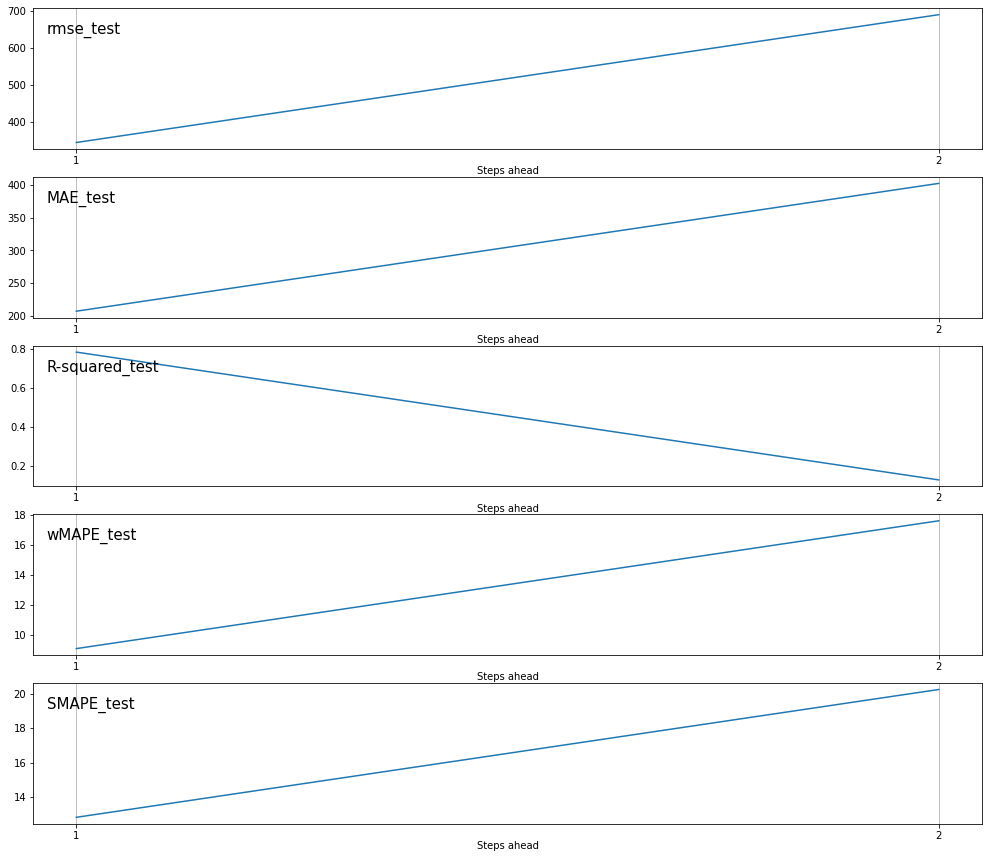

In [ ]:
# plot the scores for each time step of the multi-step forecast
scores = pd.DataFrame({"rmse_test":rmse_test, "MAE_test":MAE_test, "R-squared_test":r2_test, "wMAPE_test":wMAPE_test, "SMAPE_test":SMAPE_test})

# Reset the index, keeping the old index as a column
scores = scores.reset_index(drop=False)

# Set the 'index' column as the new index
scores.index = scores['index'] + 1

# Drop the old 'index' column
scores = scores.drop(columns='index')

data = scores.columns

# Creating figure with two rows and one column
fig, axs = plt.subplots(nrows=len(data), figsize=(17, 15))

axs = axs.ravel()

for id, column in enumerate(data):
    # Set the x-axis limits
    #axs[id].set_xlim(xmin=1, xmax= steps_ahead)
    #print the name of the test on plot
    axs[id].plot(scores[column])
    # Add a title to the x-axis
    axs[id].set_xlabel('Steps ahead',fontsize=10, labelpad=0.1)
    axs[id].grid(True)
    # Remove the horizontal grid lines
    axs[id].grid(which='both', axis='y')
    axs[id].xaxis.set_major_locator(plt.MultipleLocator(1))
    axs[id].legend([column], loc='upper left', fontsize=15, handlelength=0, handletextpad=0, frameon=False)
    
plt.show()

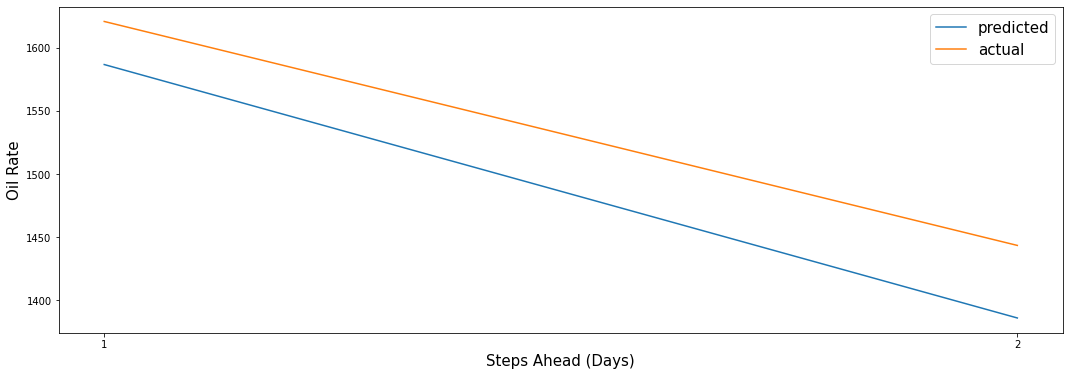

In [ ]:
# plot the last forecasted values on test set
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
# Set the major locator for the x-axis
x = list(range(1, len(inv_yhat[-1])+1))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.plot(x, inv_yhat[-1], label = "predicted")
ax.plot(x, inv_y[-1], label = "actual")
ax.set_ylabel('Oil Rate', fontsize=15)
ax.set_xlabel('Steps Ahead (Days)',fontsize=15)
plt.legend(fontsize=15)
plt.show()